In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pywt
from PyEMD import *
import scipy.io as io
from mpl_toolkits.mplot3d import Axes3D
print(1)

1


In [2]:
class bearing:
    da = {}
    de,fe,ba = [],[],[]
    sampling_rate = 0
    
    def __init__(self,ad,rate):    
        self.da = io.loadmat(str(ad)+'.mat')
        self.de = np.array([x[0] for x in self.da['X'+str(ad)+'_DE_time']])
        self.fe = np.array([x[0] for x in self.da['X'+str(ad)+'_FE_time']])
        self.ba = np.array([x[0] for x in self.da['X'+str(ad)+'_BA_time']])
        self.sampling_rate = rate
        return
    
    def STFT_img(self,data,name = 'hann'):
        #短时傅里叶变换
        f, t, zxx = signal.stft(data,fs = self.sampling_rate,window = 'hann',nperseg = 128,noverlap=127)
        plt.figure(figsize = (12, 4))
        plt.contourf(t,f, np.abs(zxx))
        plt.colorbar()
        plt.title('STFT Manitude' + '-' + name)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        fig = plt.figure(figsize=(12, 9))
        axes3d = Axes3D(fig)
        print(t.shape,f.shape,zxx.shape)
        T,F=np.meshgrid(t,f)
        print(F.shape,T.shape,zxx.shape)
        axes3d.plot_surface(F,T, np.abs(zxx))
        axes3d.set_xlabel('Frequency [Hz]')
        axes3d.set_ylabel('Time [sec]')
        axes3d.set_zlabel('STFT')
        return 
    
    def CWT_img(self,data,name = 'morl',wavename = 'morl'):
        #连续小波分析
        '''墨西哥帽小波"mexh"
        Morlet小波"morl"
        复数Morlet小波（"cmorB-C"浮点值B，C）
        高斯小波（"gausP"其中P是1到8之间的整数）
        复数高斯小波（"cgauP"其中P是1到8之间的整数）
        香农小波（"shanB-C"具有浮点值B和C）哪里 B 是带宽和 C 是中心频率。
        频率B样条小波（"fpspM-B-C"具有整数M和浮点B，C）
        M  是样条顺序， B 是带宽和 C 是中心频率。
        '''
        T = 1.0 / self.sampling_rate
        #采样周期
        t = np.arange(0, len(data) * T, T)
        fc = pywt.central_frequency(wavename)
        #中心频率
        totalscal = 20
        #小波尺度
        cparam = 2 * fc * totalscal
        #计算小波尺度
        scales = cparam / np.arange(totalscal, 0, -1)
        [cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, T)
        plt.figure(figsize = (12, 4))
        plt.plot(t, data)
        plt.figure(figsize = (12, 4))
        plt.contourf(t, frequencies, abs(cwtmatr))
        plt.colorbar()
        plt.title('CWT Manitude' + '-' + name)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        return
    
    def CYWT_img(self,data,wavelet,maxlevel = 3):
        #小波包分析
        plt.rcParams['font.sans-serif'] = ['Simhei']
        #正常显示中文字体
        plt.rcParams['axes.unicode_minus'] = False
        #显示正负号
        energy = []
        wp = pywt.WaveletPacket(data = data,wavelet = wavelet,mode = 'symmetric',maxlevel = maxlevel)
        freqTree = [node.path for node in wp.get_level(maxlevel,'freq')]
        freqBand = self.sampling_rate / (2 ** maxlevel)

        fig,axes = plt.subplots(len(freqTree) + 1,1,figsize = (10,7))
        axes[0].plot(data)
        axes[0].set_title('原始数据')

        for i in range(len(freqTree)):
            axes[i + 1].plot(wp[freqTree[i]].reconstruct(update = True))
            axes[i + 1].set_title('S'+str(i + 1),y = 0.15,x = 1.02)
            energy.append(pow(np.linalg.norm(wp[freqTree[i]].data,ord=None),2))
        plt.figure(figsize = (12,4))
        plt.bar(np.arange(2 ** maxlevel),energy)
        plt.xlabel('频带段')
        plt.ylabel('振动能量')
        return
    
    def EMD_img(self,data):
        #EMD分析
        T = 1.0 / self.sampling_rate  # 采样周期
        t = np.arange(0, len(data) * T, T)
        emd = EMD()
        emd.emd(data, t)
        # 提取IMF，与残差
        IMFs,res=emd.get_imfs_and_residue()
        # 绘制IMF
        vis1 = Visualisation()
        vis1.plot_imfs(imfs=IMFs,residue=res,t=t,include_residue=True)
        # 绘制并显示所提供IMF的瞬时频率
        vis2 = Visualisation()
        vis2.plot_instant_freq(t,imfs=IMFs)
print(1)

1


(1201,) (65,) (65, 1201)
(65, 1201) (65, 1201) (65, 1201)


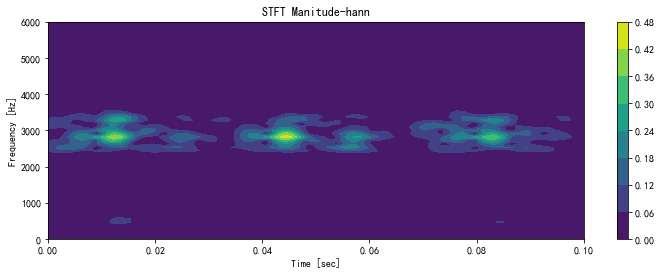

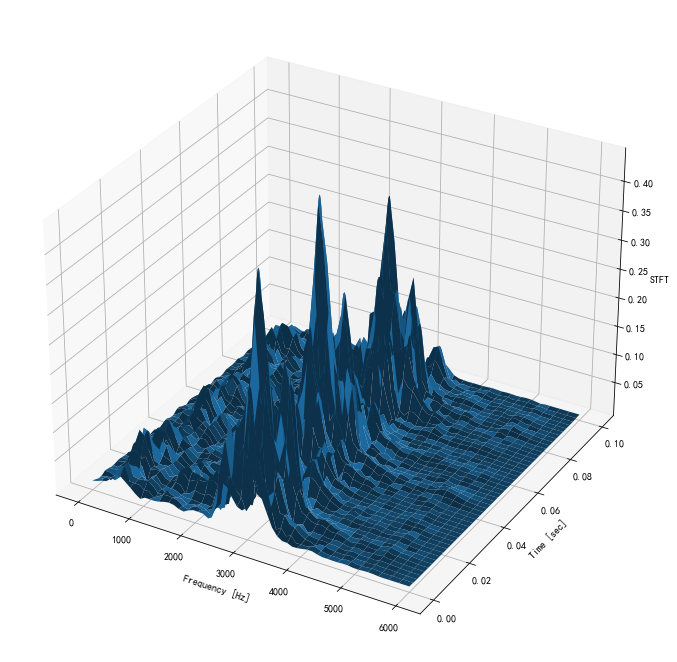

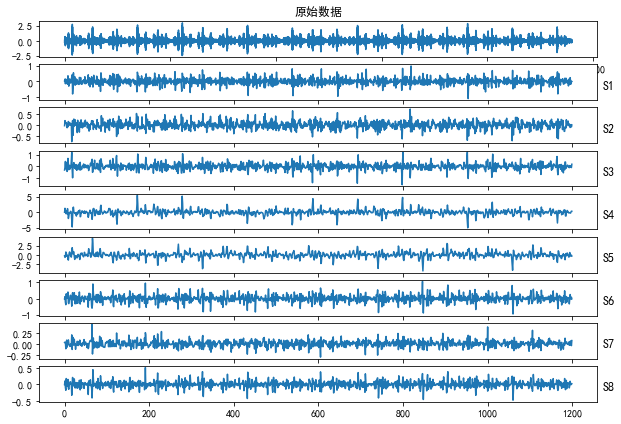

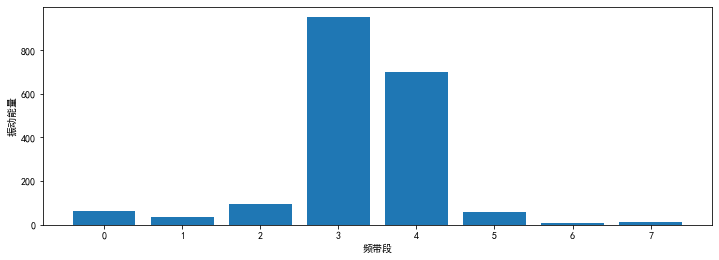

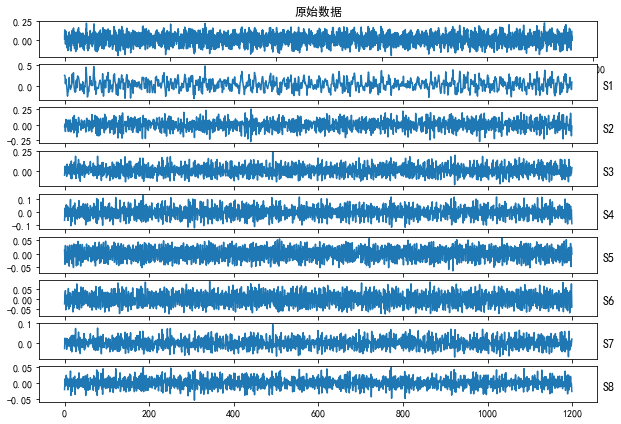

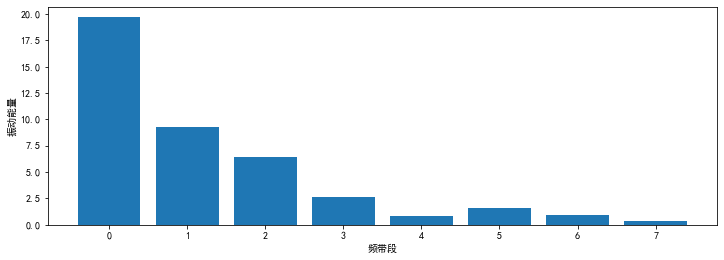

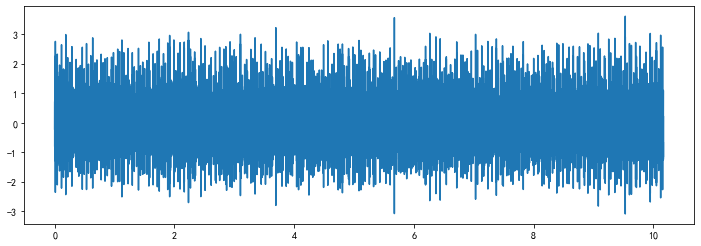

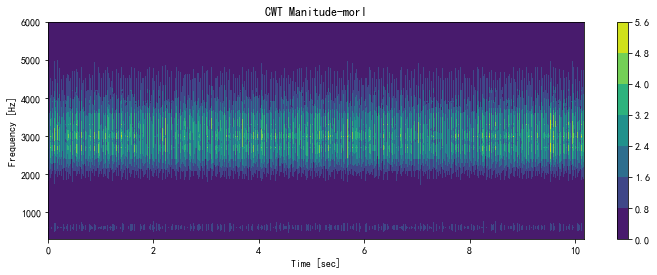

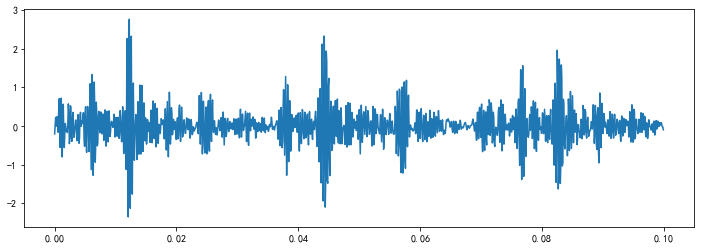

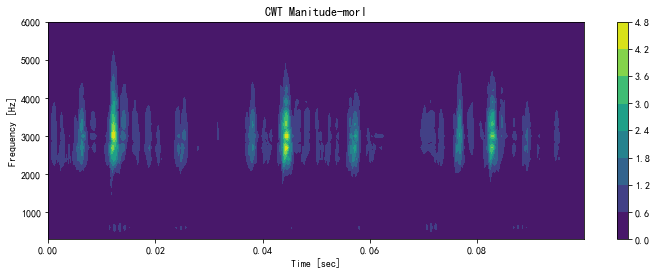

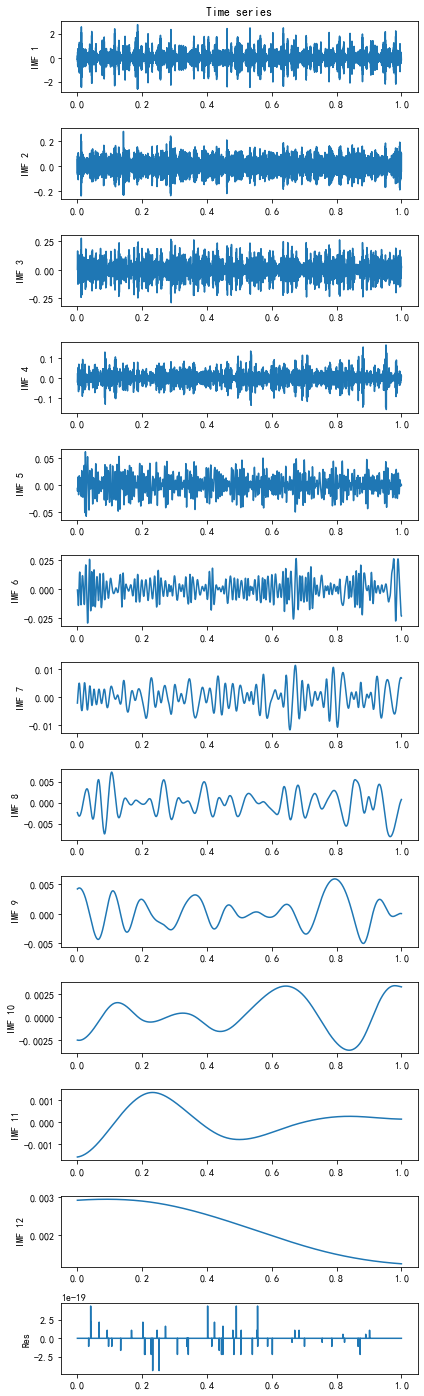

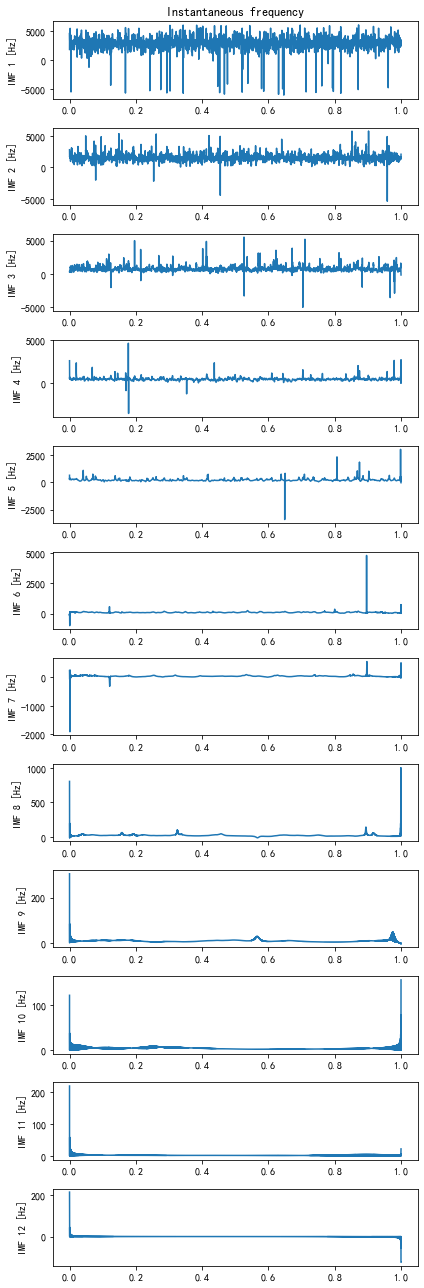

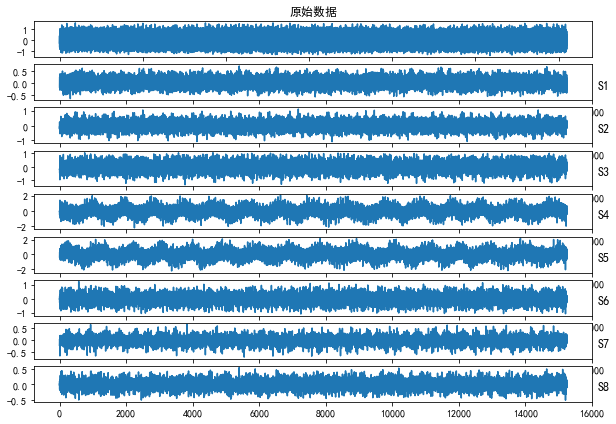

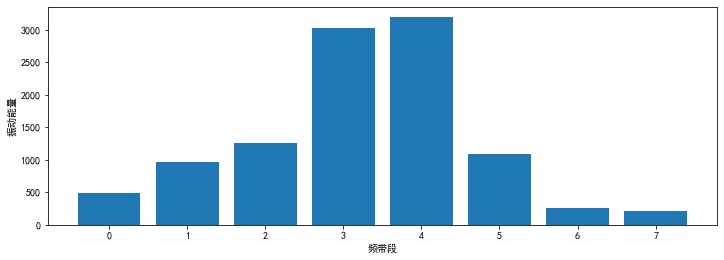

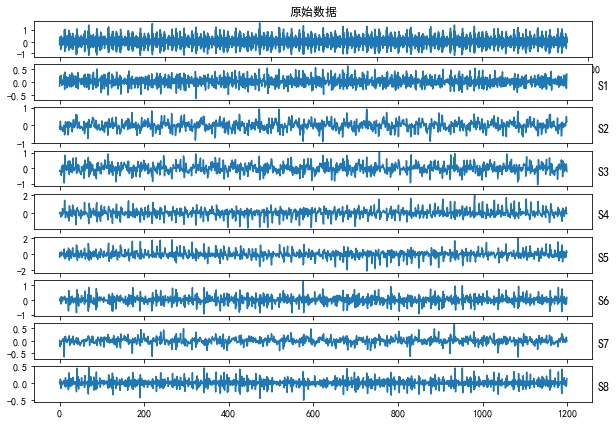

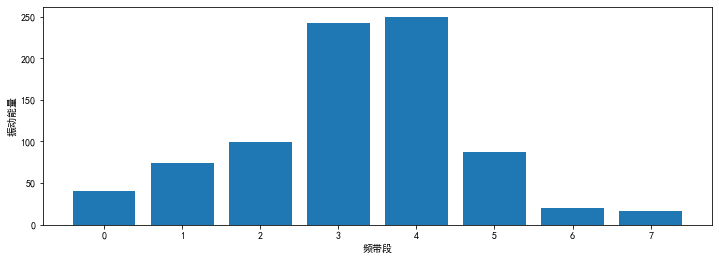

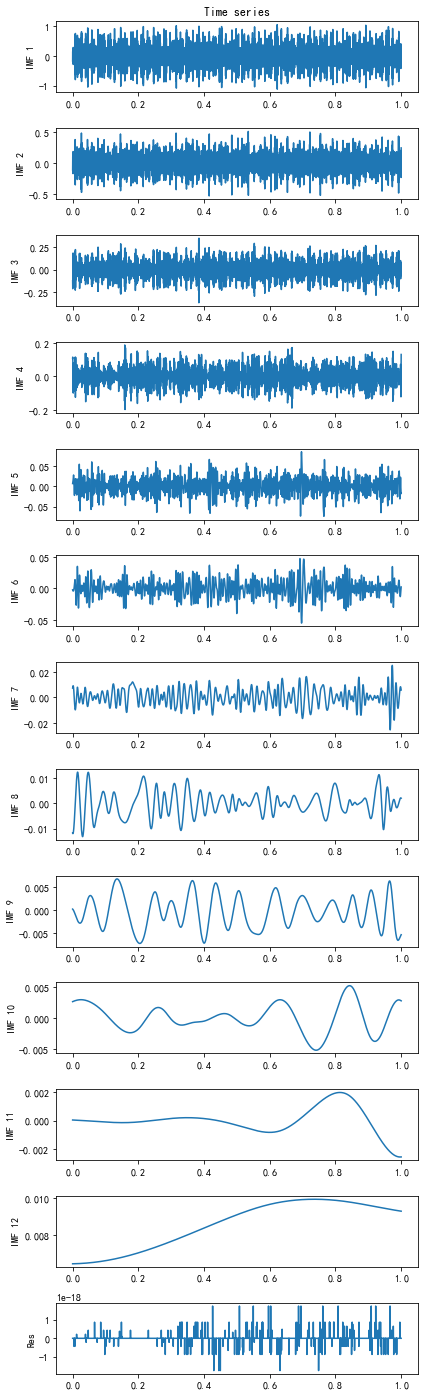

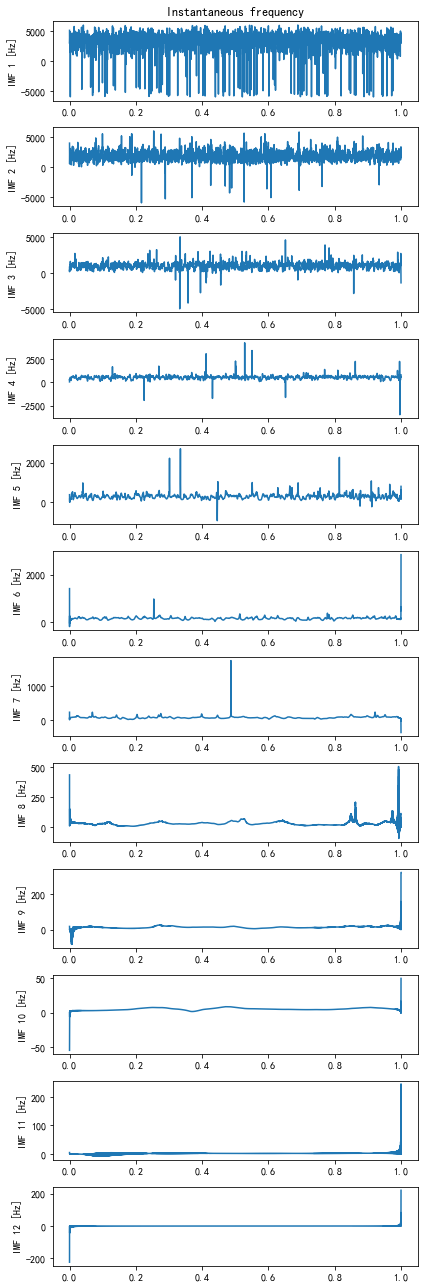

In [3]:
b100 = io.loadmat('100.mat')
de_100 = np.array([x[0] for x in b100['X100_DE_time']])
b212 = bearing(212,12000)
b212.STFT_img(b212.de[:1200])
b212.CYWT_img(b212.de[:1200*8],'db1')
b212.CYWT_img(de_100[:1200*8],'db1')
b212.CWT_img(b212.de)
b212.CWT_img(b212.de[:1200])
b212.EMD_img(b212.de[:12000])
#
b106 = bearing(106,12000)
b106.CYWT_img(b106.de,'db1')
b106.CYWT_img(b106.de[:1200*8],'db1')
b106.EMD_img(b106.de[:12000])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as io
import pandas as pd
from scipy.fft import fft,ifft
from pandas import Series,DataFrame
import math
import seaborn as sns
print(1)

1


In [8]:
class date:
    da = []             #数据
    da_mean = 0         #均值
    da_msv = 0          #均方值
    da_rms = 0          #均方根
    da_var = 0          #方差
    da_std = 0          #标准差
    da_waveform = 0     #波形指标
    da_peak = 0         #峰值指标
    da_impluse = 0      #脉冲指标
    da_clearance = 0    #裕度指标
    da_alpha = 0        #偏斜度
    da_beta = 0         #峭度
    da_skew = 0         #偏斜度指标
    da_kurt = 0         #峭度指标
    
    def  __init__(self,d):
        self.da = d
        self.da_mean = d.mean()
        self.da_var = d.var()
        self.da_msv = self.da_mean**2+self.da_var
        self.da_std = d.std()
        self.da_rms = self.da_msv**0.5
        x_ = abs(d).mean()
        xp = max(d)
        self.da_waveform = self.da_rms/x_
        self.da_peak = xp/self.da_rms
        self.da_impluse = xp/x_
        self.da_clearance = xp/(sum([math.sqrt(i) for i in abs(d)])/len(d))**2
        self.da_alpha = pd.Series(d).skew()
        self.da_beta = pd.Series(d).kurt()
        self.da_skew = self.da_alpha/self.da_std**3
        self.da_kurt = self.da_beta/self.da_std**4
        return
        
    def print_date(self):
        print('均值\t\t\t%f' %self.da_mean)
        print('均方值\t\t%f' %self.da_msv)
        print('均方根\t\t%f' %self.da_rms)
        print('方差\t\t\t%f' %self.da_var)
        print('标准差\t\t%f' %self.da_std)
        print('波形指标\t\t%f' %self.da_waveform)
        print('峰值指标\t\t%f' %self.da_peak)
        print('脉冲指标\t\t%f' %self.da_impluse)
        print('裕度指标\t\t%f' %self.da_clearance)
        print('偏斜度\t\t%f' %self.da_alpha)
        print('峭度\t\t\t%f' %self.da_beta)
        print('偏斜度指标\t%f' %self.da_skew)
        print('峭度指标\t\t%f' %self.da_kurt)
        return
    
class bearing:
    da = {}
    de,fe,ba = [],[],[]
    sampling_rate = 0
    
    def __init__(self,ad,rate):    
        self.da = io.loadmat(str(ad)+'.mat')
        self.de = np.array([x[0] for x in self.da['X'+str(ad)+'_DE_time']])
        self.fe = np.array([x[0] for x in self.da['X'+str(ad)+'_FE_time']])
        self.ba = np.array([x[0] for x in self.da['X'+str(ad)+'_BA_time']])
        self.sampling_rate = rate
        return
    
    def __pl(self,x,y,xlabel,ylabel,title):
        #内部绘图函数
        plt.figure(figsize = (12,4))
        plt.plot(x,y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        return
    
    def __FFT(self,da):
        #内部傅里叶变换函数
        N = len(da)
        df = self.sampling_rate/N
        f = np.arange(0,self.sampling_rate / 2,df)
        y = fft(da)
        yf = abs(y)[0:len(f)]
        return [f,yf]
    
    def ft_img(self,da):
        #绘制信号的时域图像
        N = len(da)
        dt = 1 / self.sampling_rate
        t = np.arange(0,N*dt,dt)
        self.__pl(t,da,'t/s','x(t)','Signal')
        return
    
    def fft_img(self,da,title):
        #对信号进行傅里叶变换并绘制其频谱图像
        f = self.__FFT(da)       
        self.__pl(f[0],f[1],'fs/Hz','al',str(title)  + ' FFT')
        return
    
    def corx_img(self,da):
        #对信号进行自相关分析并绘制其自相关图像和自谱图像
        cor_x = np.correlate(da,da,'full')
        de1 = np.arange(len(cor_x) / 2, 0, -1)
        de = np.hstack([de1[::-1], de1[1:]])
        dt=1/self.sampling_rate
        x = np.arange(-(len(cor_x)-1)/2*dt,((len(cor_x)-1)/2+1)*dt,dt)
        self.__pl(x,cor_x/de,'t/s','al','Autucorrelation')
        f = self.__FFT(cor_x/de)
        self.__pl(f[0],f[1],'fs/Hz','al','Self power spectrum')
        return
    
    def corxy_img(self,dax,day):
        #对信号进行互相关分析并绘制其互相关图像和互谱图像
        cor_xy = np.correlate(dax,day,'full')
        N = len(cor_xy)
        x = range(-N//2,N//2)
        self.__pl(x,cor_xy,'t/s','al','Cross-correlation')
        f = self.__FFT(cor_xy)
        self.__pl(f[0],f[1],'fs/Hz','al','Cross power spectrum')
        return
    
    def pro_den_img(self,da):
        #绘制信号的概率密度函数图像
        plt.figure(figsize = (12,4))
        sns.distplot(da,bins = 500)
        sns.kdeplot(da)
        plt.title('Probability density function')
        return
    
    def compare_fft(self,da1,da2):
        #比较两个信号的频谱
        f1 = self.__FFT(da1)
        f2 = self.__FFT(da2)
        delta_f = [f2[1][i]-f1[1][i] for i in range(0,len(f1[0]))]
        self.__pl(f1[0],delta_f,'fs/Hz','delta_al','Compare FFT')
        return
print(1)

1


均值			0.002846
均方值		0.201362
均方根		0.448734
方差			0.201354
标准差		0.448725
波形指标		1.481246
峰值指标		8.055989
脉冲指标		11.932904
裕度指标		15.364340
偏斜度		0.303177
峭度			5.345390
偏斜度指标	3.355494
峭度指标		131.843733


F:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


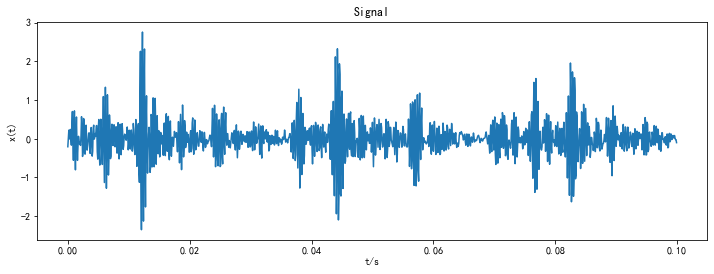

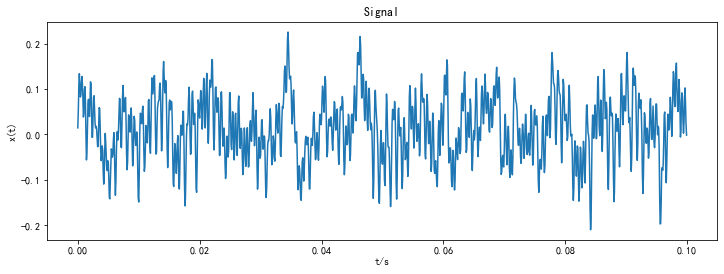

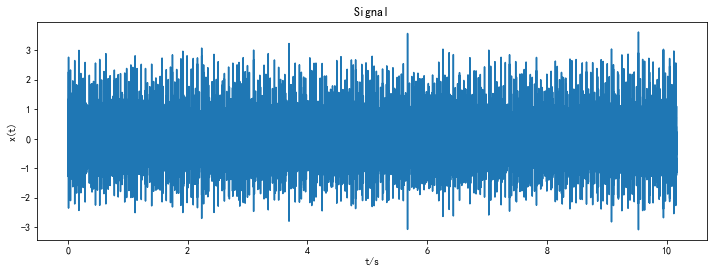

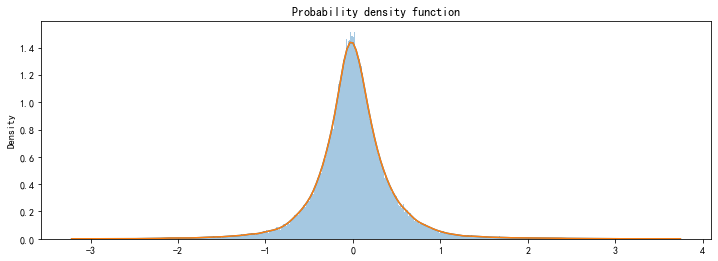

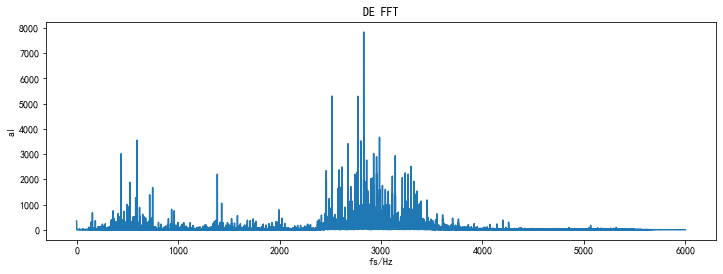

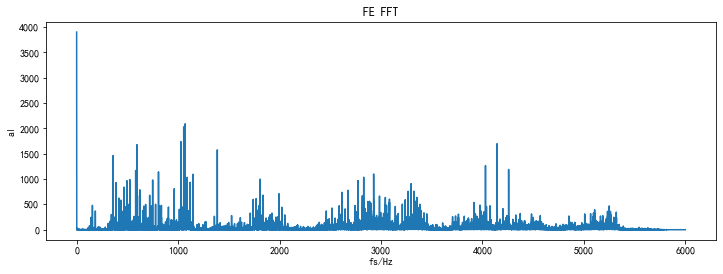

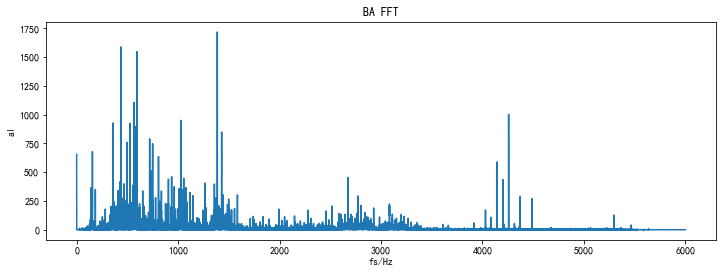

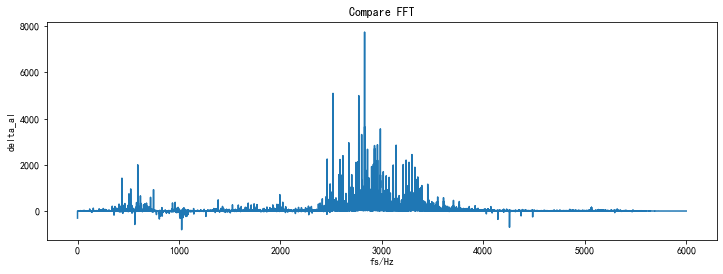

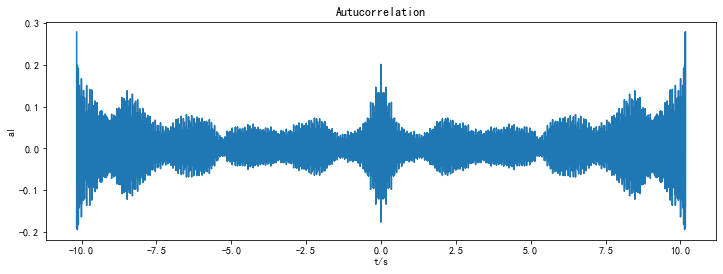

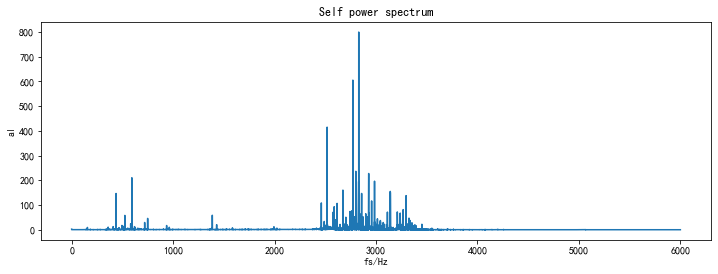

In [10]:
b212 = bearing(212,12000)
b212.ft_img(b212.de[0:1200])
b212.ft_img(de_100[0:1200])
d212_de = date(b212.de)
d212_de.print_date()
b212.ft_img(b212.de)
b212.pro_den_img(b212.de)
b212.fft_img(b212.de,'DE')
b212.fft_img(b212.fe,'FE')
b212.fft_img(b212.ba,'BA')
b212.compare_fft(b212.ba,b212.de)
b212.corx_img(b212.de)